kaggle比赛实例：使用正则化线性模型来预测房价，涉及到xgboost调参
====================


In [101]:
# 导入库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skew
from scipy import stats

%matplotlib inline

In [102]:
# 读入训练和测试数据
train = pd.read_csv('F:\\study\\projects\\kaggle\\House Prices\\data\\train.csv')
test = pd.read_csv('F:\\study\projects\\kaggle\\House Prices\\data\\test.csv')

In [103]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [104]:
# 查看特征类型
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


可以看到特征的类型有浮点型、整数型和分类类型  
（选做）统计每种类型变量的个数

In [105]:
types = pd.DataFrame(train.dtypes)
types.columns = ['Type']
types_count = pd.DataFrame(types['Type'].value_counts())
types_count.columns = ['Count']
types_count

,Count
object,43
int64,35
float64,3


#### 将train和test数据集合并，方便一起做数据预处理

In [106]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

数据预处理
---------------
这里只是做了简单的数据预处理操作
* 观察特征的分布，通过对数变换使特征更接近正态分布
* 为分类特征创建哑变量（dummy variables）
* 将缺失值用各自列的均值代替

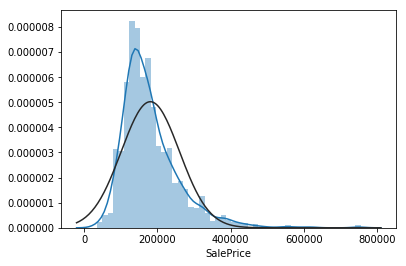

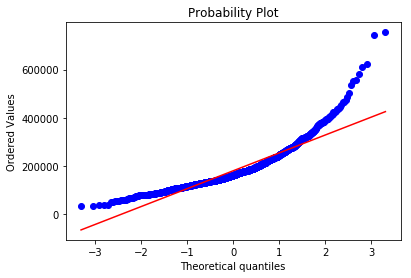

In [107]:
# 观察SalePrice变量的分布情况
sns.distplot(train['SalePrice'], fit = norm) # 与正态分布直方图作比较
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt) # 画出正态概率图

很明显‘SalePrice’的数据分布不符合正态分布，现在使用log(feature+1)变换改善这种局面

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001ED3DCF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001F5D7518>]], dtype=object)

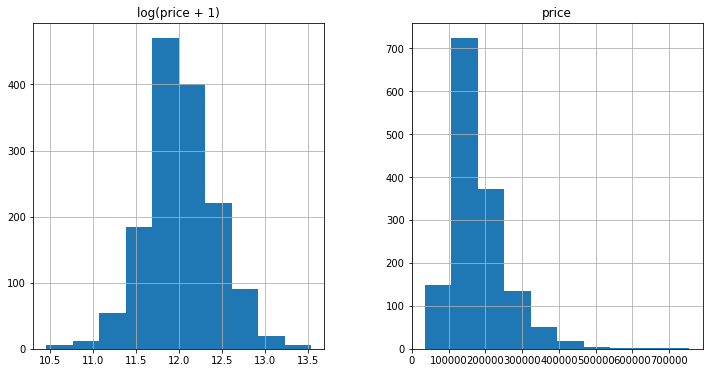

In [108]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

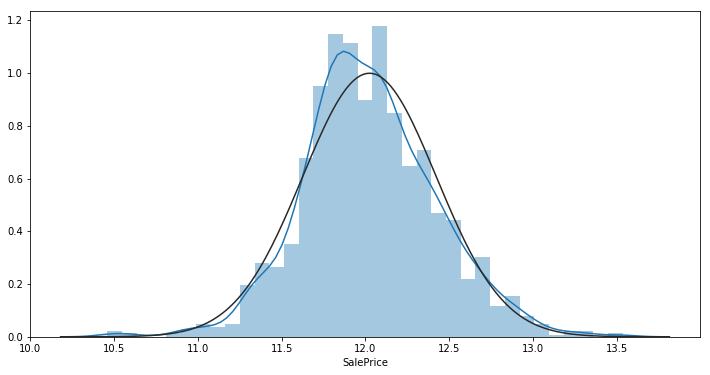

In [109]:
# log transform the target--“saleprice”
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit = norm)

#### 对数字特征（即非 分类类型特征“object”）做对数变换

In [110]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


#### 为分类型特征创建哑变量，操作上就是调用get_dummies进行独热编码

In [111]:
all_data = pd.get_dummies(all_data)
#all_data.dtypes # 会发现已经没有‘object’类型的特征
all_data.shape # (2919, 288)
all_data.columns


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=288)

经过创建哑变量之后特征从原先的79个增长到288个，这是因为独热编码增加了特征的维度

#### 对于缺失值用每列的均值代替

In [112]:
# filling NA's with the mean of the column
all_data = all_data.fillna(all_data.mean())

In [113]:
# 分离出训练和测试数据集
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

模型
======
这里直接调用scikit learn库中的正则化线性回归(regularized linear regression)，将尝试L1(Lasso)和L2(Ridge)正则化。定义一个返回交叉验证的平方根误差（the cross-validation rmse error）的函数来评估模型的好坏，并指导我们调整参数。

In [114]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#定义交叉验证的平方根误差的评估函数
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model,X_train,y,scoring='neg_mean_squared_error',cv=5))
    return rmse

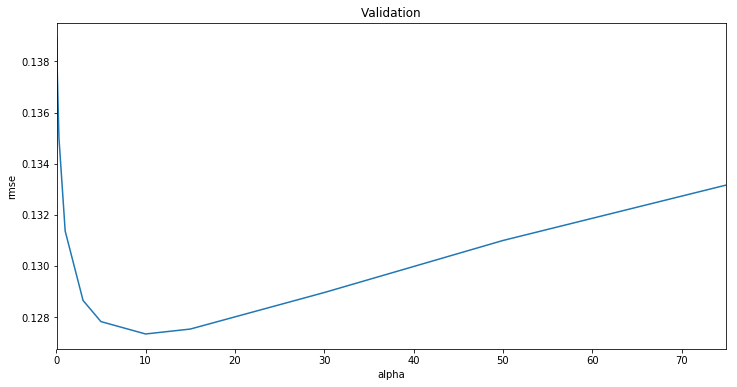

In [115]:
# L2 regularization
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation')

plt.xlabel('alpha')
plt.ylabel('rmse')

从图中可以看到，当alpha太大时，正则化太强，模型不能捕获数据集中复杂的特征，但是当alpha太小时模型会过拟合，在这幅图中可以认为alpha=10是比较合适的

In [116]:
cv_ridge.min()

0.12733734668670749

使用Ridge regression 得到的交叉验证平方根误差rmse为0.1273

#### 现在来尝试Lasso模型（L1 正则化）的效果

In [117]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12314421090977438

### 这里使用Lasso来做预测。Lasso的一个好处是他为我们选择了特征-将他认为不重要的特征系数置为零：

In [118]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
YearBuilt                0.001777
YearRemodAdd             0.000722
MasVnrArea              -0.000194
BsmtFinSF1               0.009292
BsmtFinSF2              -0.001385
BsmtUnfSF               -0.003975
TotalBsmtSF              0.019208
1stFlrSF                 0.030350
2ndFlrSF                -0.003396
LowQualFinSF            -0.003880
GrLivArea                0.400009
BsmtFullBath             0.025674
BsmtHalfBath             0.000000
FullBath                 0.021307
HalfBath                 0.013793
BedroomAbvGr            -0.001004
KitchenAbvGr            -0.009937
TotRmsAbvGrd             0.005079
Fireplaces               0.022117
GarageYrBlt              0.000029
GarageCars               0.038789
GarageArea               0.000051
WoodDeckSF               0.004409
OpenPorchSF              0.001631
EnclosedPorch 

可以将Lasso选择的特征统计出来，并查看舍弃了多少特征

In [119]:
print('Lasso picked '+str(sum(coef!=0)) + ' variables and eliminated the other '+ str(sum(coef==0)) + ' variables')

Lasso picked 111 variables and eliminated the other 177 variables


#### 也可以直观的查看究竟选择了哪些特征以及对应的系数大小

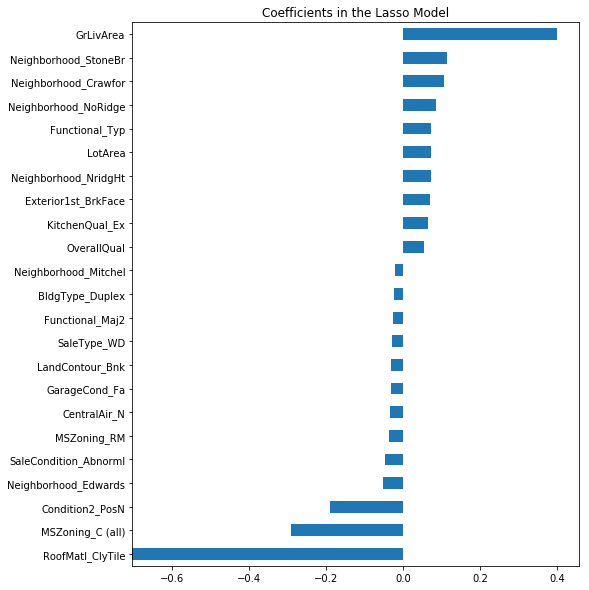

In [120]:
imp_coef = pd.concat([coef.sort_values().head(13), coef.sort_values().tail(10)])

# show
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')

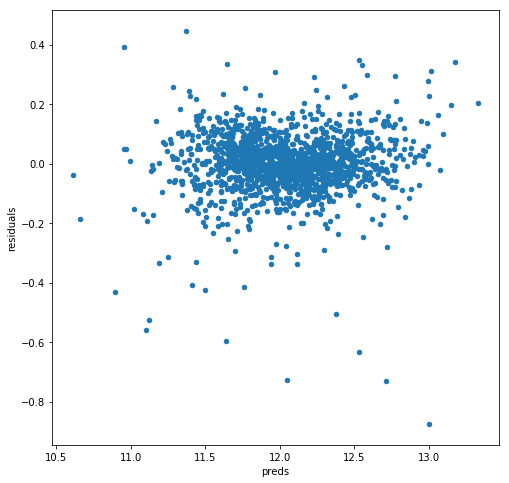

In [126]:
# 查看预测结果与真实值的残差分布图
matplotlib.rcParams['figure.figsize'] = (8, 8)

preds = pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')

残差值绝大部分集中在0附近，只有少数离群点，预测的效果看起来还算靠谱……

### 融合xgboost模型
给之前的线性模型融合一个xgboost模型，看看对结果有没有提升作用

In [153]:
import xgboost as xgb

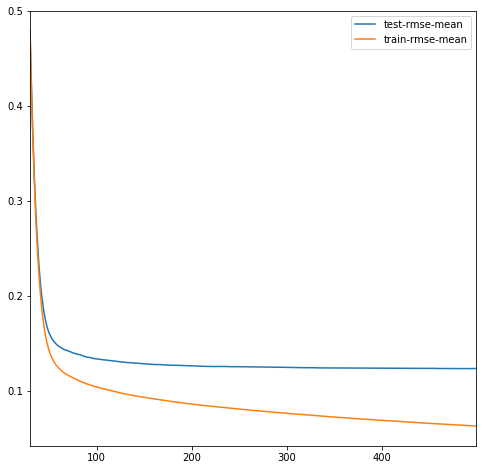

In [152]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth':2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

从图中可以看到，在迭代接近500次后验证集上的误差几乎不再变化。  
early_stopping_rounds设置为100，意思是说，如果在经历了100次迭代都效果都没有提升的话就stop

In [150]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [142]:
xgb_preds = np.expm1(model_xgb.predict(X_test)) # expm1:Calculate exp(x) - 1 for all elements in the array.
lasso_preds = np.expm1(model_lasso.predict(X_test))

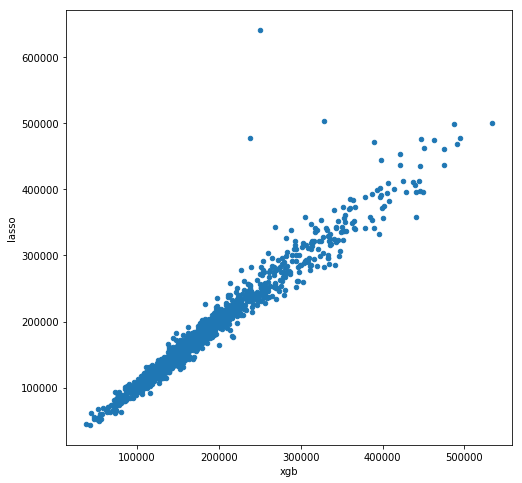

In [143]:
# 画出lasso与xgb模型在测试集中的效果对比的散点图
predictions = pd.DataFrame({'xgb':xgb_preds, 'lasso':lasso_preds})
predictions.plot(x = 'xgb', y = 'lasso', kind = 'scatter')

In [144]:
# 融合lasso模型和xgboost模型
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [146]:
# output the predict result,save as .csv file
solution = pd.DataFrame({'id':test.Id, 'SalePrice':preds})
solution.to_csv('lasso&xgb model.csv', index = False)